<h1><b>Explore Zillow exercises

In [1]:
import numpy as np
import pandas as pd
import os
import env
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

directory = os.getcwd()
# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# import for scaling data
from sklearn.preprocessing import MinMaxScaler

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")
import wrangle

<h4><b>Import and Prepare Previous Zillow Data

In [2]:
SQL_query = '''
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 

FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31'
'''
from wrangle import get_data, SQL_query
df = get_data(SQL_query, directory, filename = 'zillow.csv')

from wrangle import wrangle_zillow
df = wrangle_zillow(df)

In [3]:
df.head()

Unnamed: 0  parcelid  bathroomcnt  bedroomcnt  \
0           0  14297519          3.5         4.0   
1           1  17052889          1.0         2.0   
2           2  14186244          2.0         3.0   
3           3  12177905          3.0         4.0   
4           4  10887214          3.0         3.0   

   calculatedfinishedsquarefeet    fips    latitude    longitude  \
0                        3100.0  6059.0  33634931.0 -117869207.0   
1                        1465.0  6111.0  34449266.0 -119281531.0   
2                        1243.0  6059.0  33886168.0 -117823170.0   
3                        2376.0  6037.0  34245180.0 -118240722.0   
4                        1312.0  6037.0  34185120.0 -118414640.0   

   lotsizesquarefeet  rawcensustractandblock  ...  roomcnt  yearbuilt  \
0             4506.0            6.059063e+07  ...      0.0     1998.0   
1            12647.0            6.111001e+07  ...      5.0     1967.0   
2             8432.0            6.059022e+07  ...      6.0     1962.0   
3            13038.0            6.037300e+07  ...      0.0     1970.0   
4           278581.0            6.037124e+07  ...      0.0     1964.0   

   structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
0                    485713.0          1023282.0          2016.0   
1                     88000.0           464000.0          2016.0   
2                     85289.0           564778.0          2016.0   
3                    108918.0           145143.0          2016.0   
4                     73681.0           119407.0          2016.0   

   landtaxvaluedollarcnt  taxamount  logerror  transactiondate       county  
0               537569.0   11013.72  0.025595       2017-01-01       Orange  
1               376000.0    5672.48  0.055619       2017-01-01      Ventura  
2               479489.0    6488.30  0.005383       2017-01-01       Orange  
3                36225.0    1777.51 -0.103410       2017-01-01  Los_Angeles  
4                45726.0    1533.89  0.006940       2017-01-01  Los_Angeles  

[5 rows x 23 columns]

In [4]:
df.shape

(69729, 23)

In [5]:
df.isnull().sum()

Unnamed: 0                      0
parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
transactiondate                 0
county                          0
dtype: int64

> <b>Univariate Analysis

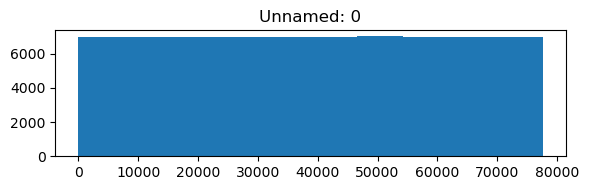

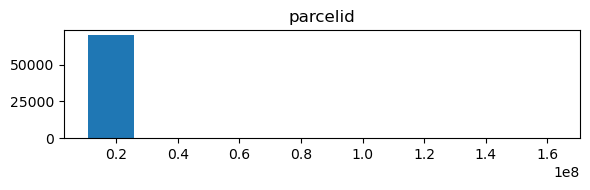

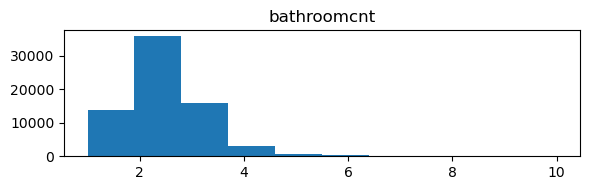

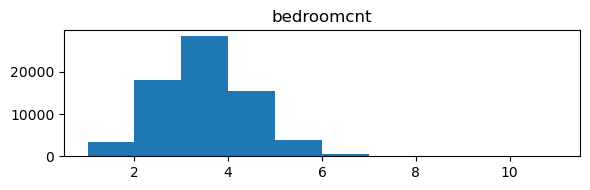

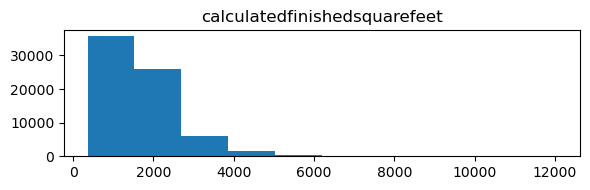

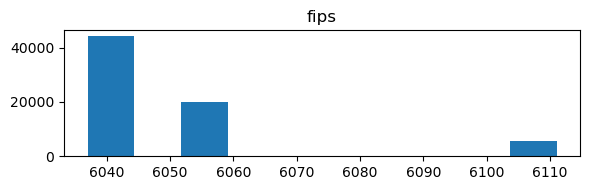

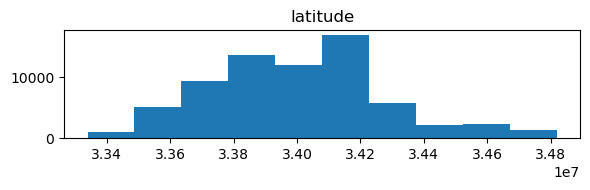

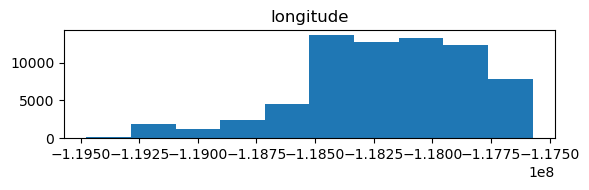

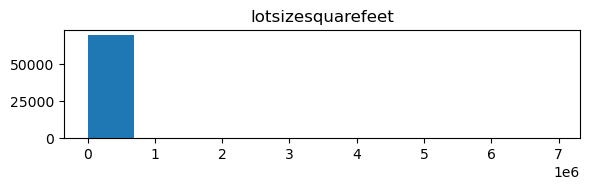

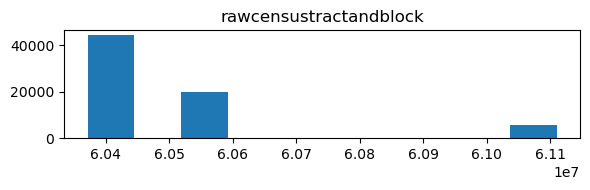

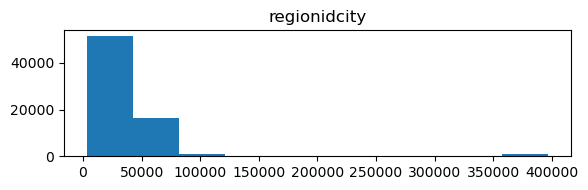

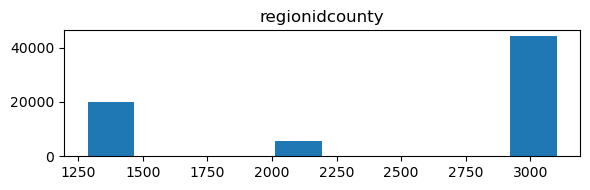

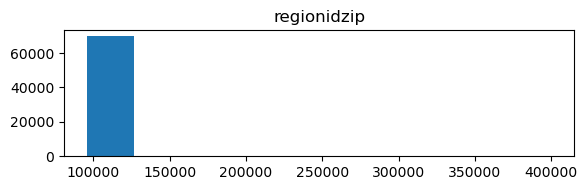

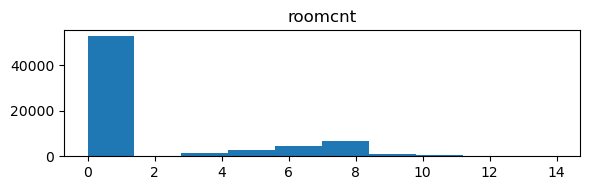

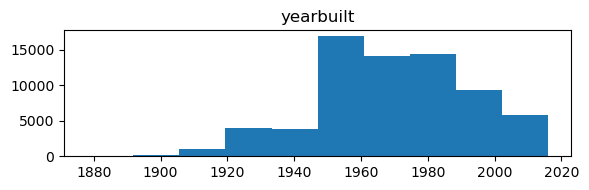

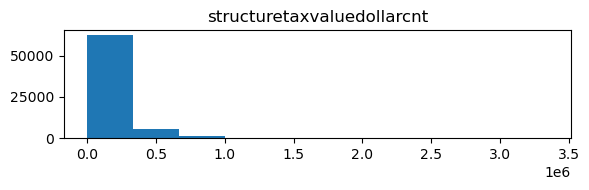

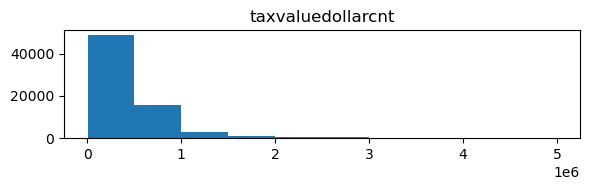

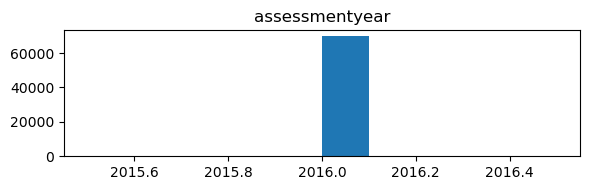

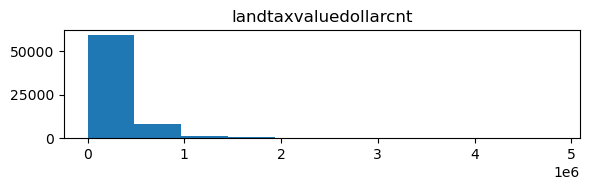

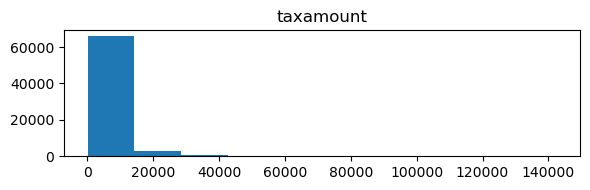

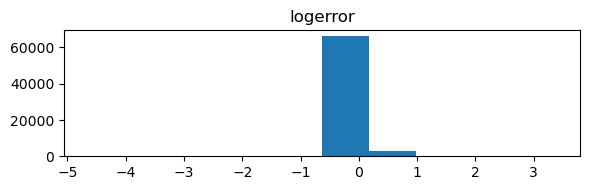

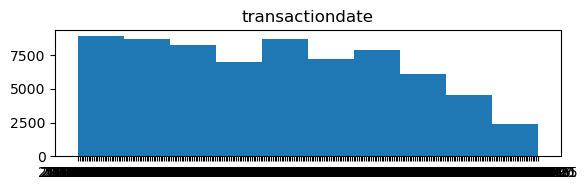

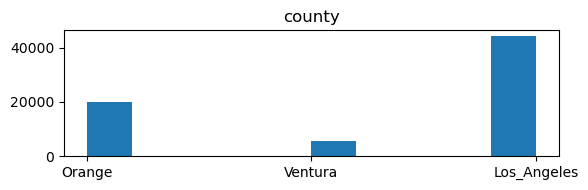

In [6]:
for col in df:
    plt.figure(figsize = (6,2))
    plt.hist(df[col])
    plt.title(f'{col}')
    plt.tight_layout();



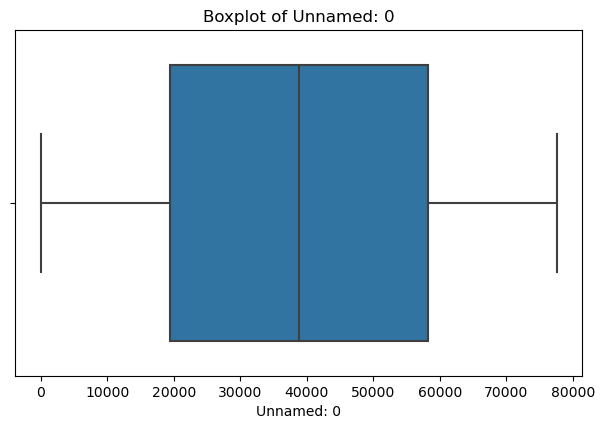

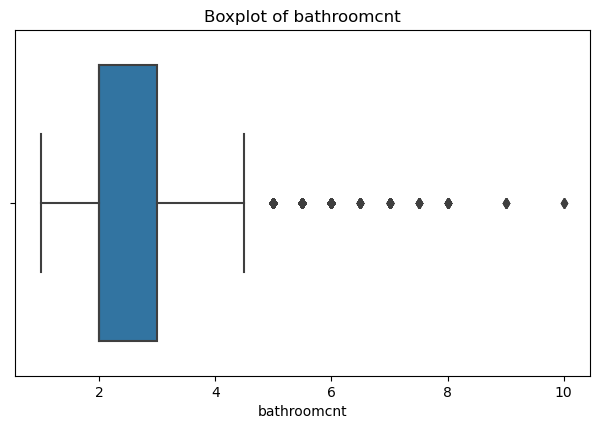

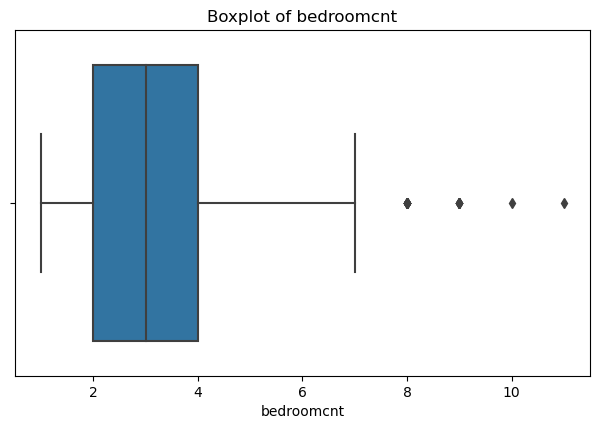

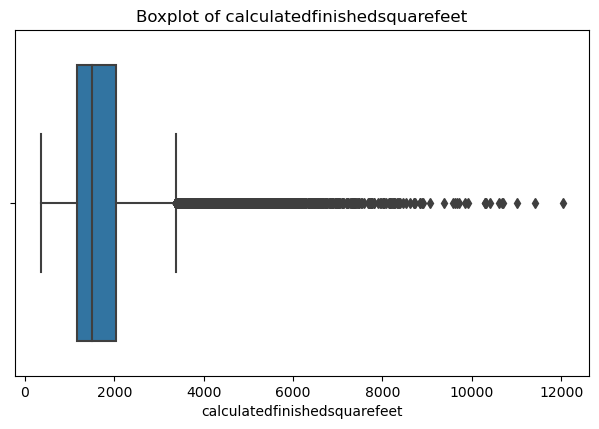

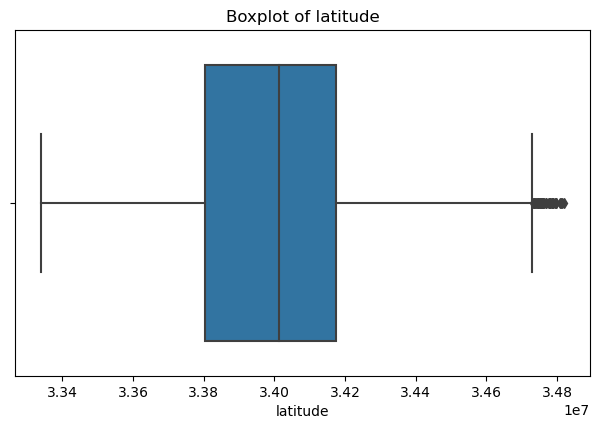

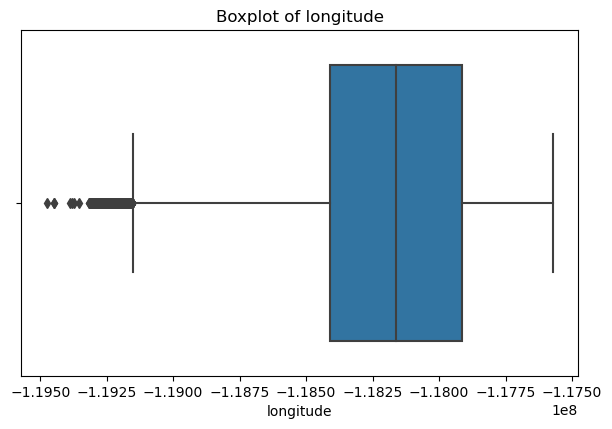

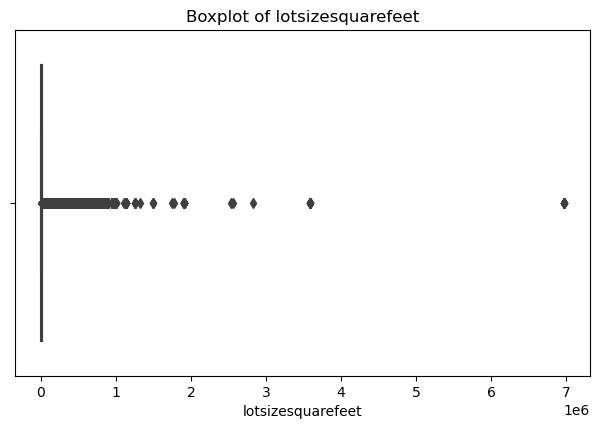

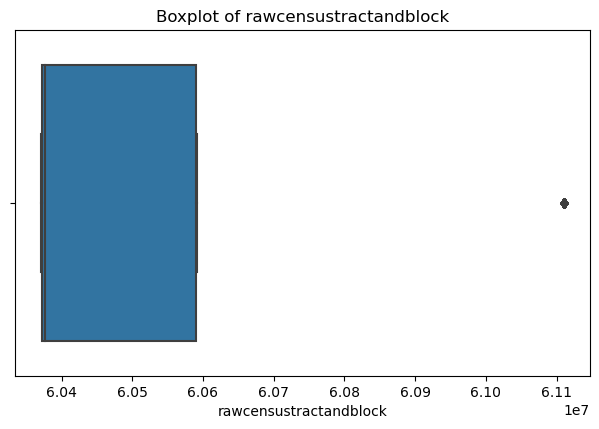

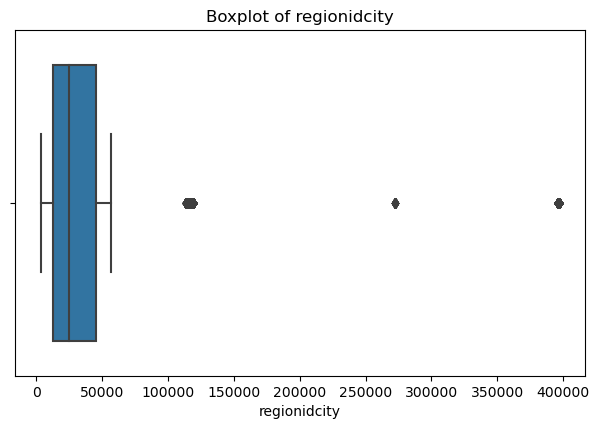

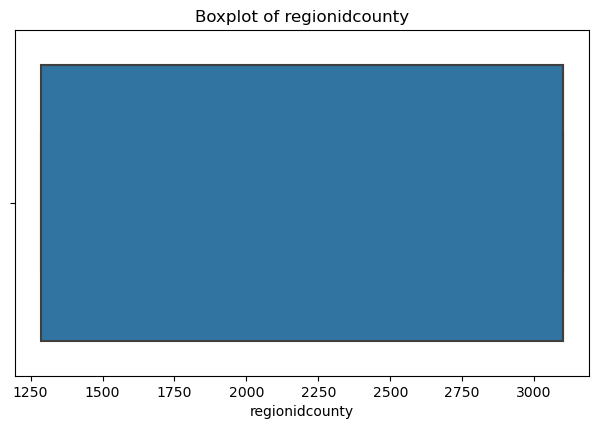

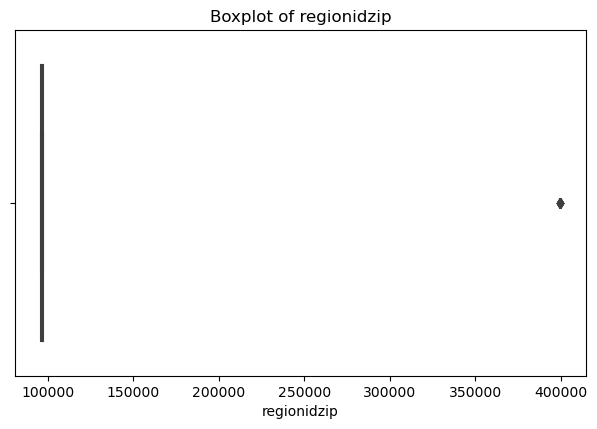

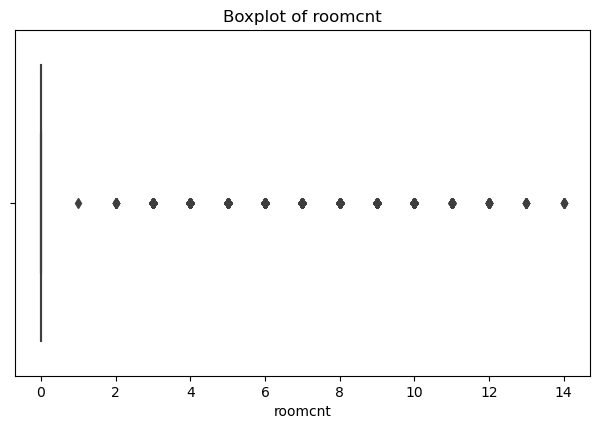

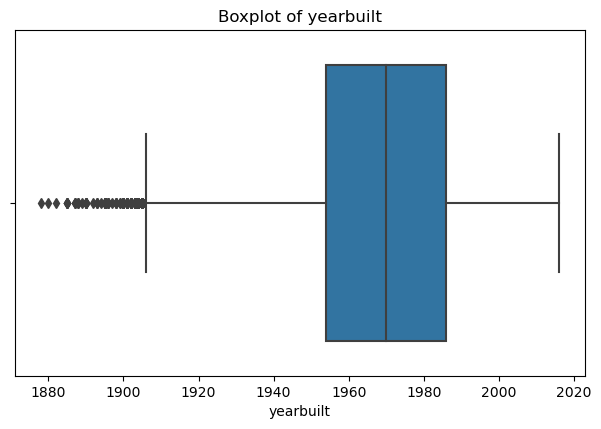

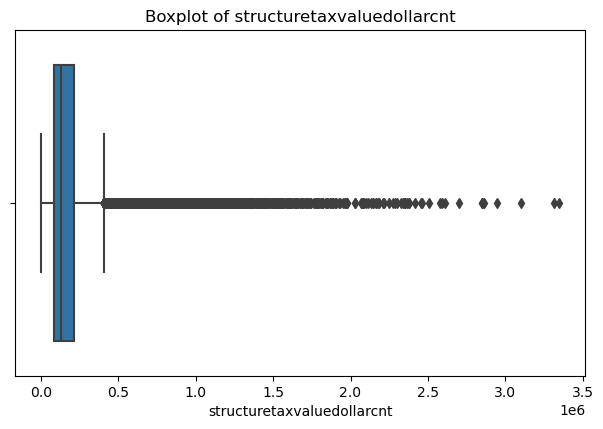

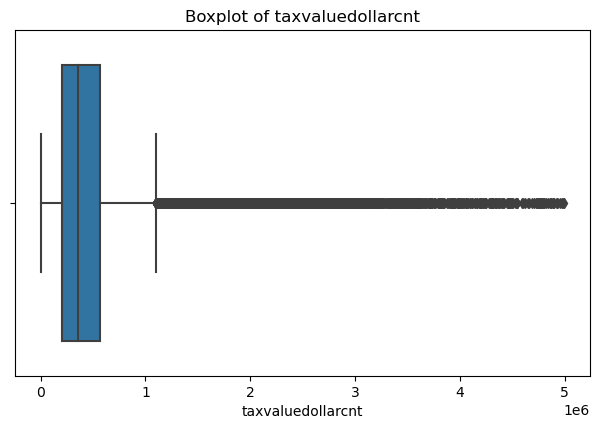

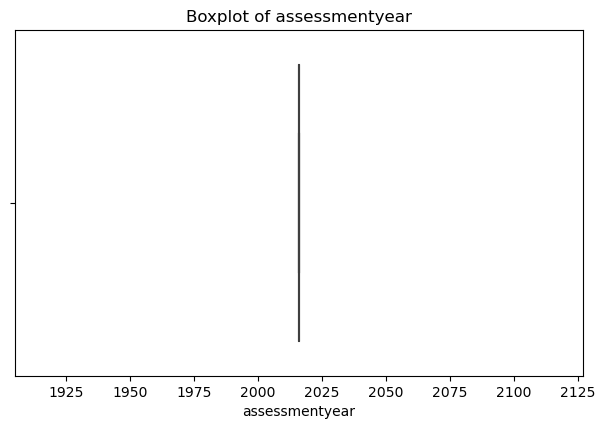

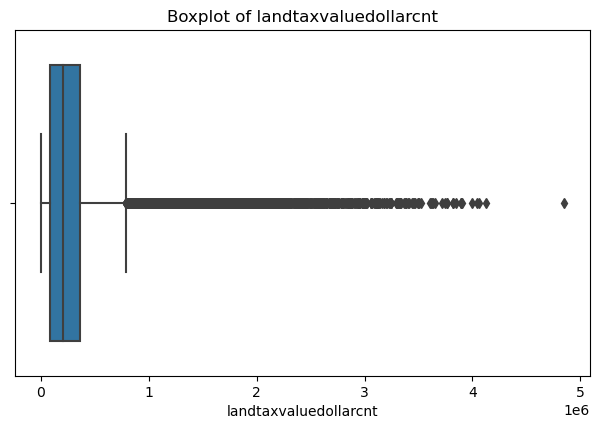

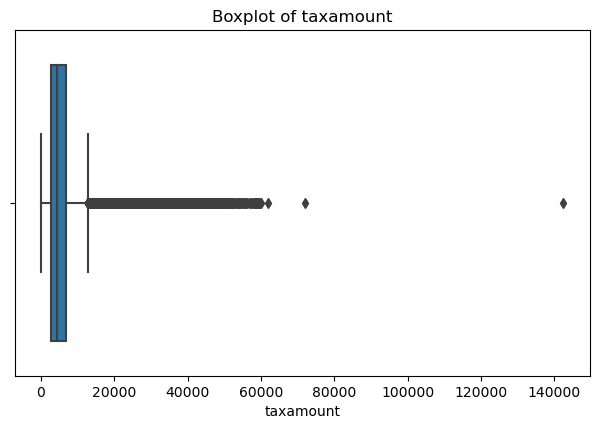

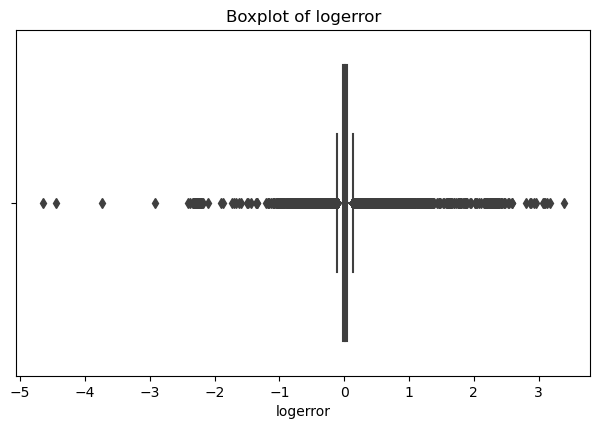

In [7]:
num_cols = df.drop(columns={'transactiondate', 'county', 'parcelid', 'fips'})

for col in num_cols:
    plt.figure(figsize = (12,8))
    plt.subplot(222)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout();

<h3><b>Split the Data before looking at more than one column!

In [8]:
from wrangle import split_data
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((39048, 23), (16735, 23), (13946, 23))

<h3><b>Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

<b>Target Variable: Logerror

> <b>Let's get some visuals to see if we notice anything

In [9]:
train.logerror.describe()

count    39048.000000
mean         0.016641
std          0.165404
min         -4.453964
25%         -0.023841
50%          0.006549
75%          0.037987
max          3.123634
Name: logerror, dtype: float64

In [10]:
train_corr = train.corr()
train_corr

Unnamed: 0  parcelid  bathroomcnt  bedroomcnt  \
Unnamed: 0                      1.000000 -0.002221    -0.000995    0.000665   
parcelid                       -0.002221  1.000000     0.048980    0.076739   
bathroomcnt                    -0.000995  0.048980     1.000000    0.591264   
bedroomcnt                      0.000665  0.076739     0.591264    1.000000   
calculatedfinishedsquarefeet   -0.004269  0.073747     0.804587    0.672570   
fips                           -0.002107  0.796151     0.081132    0.114748   
latitude                        0.000762 -0.290776     0.002221    0.070370   
longitude                      -0.008416 -0.027307    -0.000919    0.000516   
lotsizesquarefeet              -0.002247 -0.094396     0.009967   -0.086894   
rawcensustractandblock         -0.002073  0.795520     0.080974    0.115339   
regionidcity                   -0.005335 -0.016255    -0.040554   -0.025023   
regionidcounty                  0.007576 -0.623768    -0.097974   -0.088189   
regionidzip                    -0.000956  0.045992     0.035016    0.029470   
roomcnt                        -0.000643  0.593751     0.078851    0.235622   
yearbuilt                       0.004247  0.218097     0.438249    0.093973   
structuretaxvaluedollarcnt     -0.003760  0.034031     0.657104    0.363051   
taxvaluedollarcnt               0.001047  0.029498     0.540758    0.299343   
assessmentyear                       NaN       NaN          NaN         NaN   
landtaxvaluedollarcnt           0.003542  0.022594     0.395861    0.219518   
taxamount                      -0.000278  0.001622     0.541175    0.303231   
logerror                        0.011536  0.010020     0.031538    0.038001   

                              calculatedfinishedsquarefeet      fips  \
Unnamed: 0                                       -0.004269 -0.002107   
parcelid                                          0.073747  0.796151   
bathroomcnt                                       0.804587  0.081132   
bedroomcnt                                        0.672570  0.114748   
calculatedfinishedsquarefeet                      1.000000  0.111752   
fips                                              0.111752  1.000000   
latitude                                         -0.005829 -0.063966   
longitude                                         0.002187 -0.340863   
lotsizesquarefeet                                -0.039123 -0.084863   
rawcensustractandblock                            0.111533  0.999941   
regionidcity                                     -0.034754 -0.031593   
regionidcounty                                   -0.115162 -0.601252   
regionidzip                                       0.040067  0.044918   
roomcnt                                           0.153719  0.715682   
yearbuilt                                         0.268224  0.250154   
structuretaxvaluedollarcnt                        0.736304  0.065070   
taxvaluedollarcnt                                 0.624637  0.036122   
assessmentyear                                         NaN       NaN   
landtaxvaluedollarcnt                             0.469800  0.014762   
taxamount                                         0.622804  0.006684   
logerror                                          0.046802  0.006750   

                              latitude  longitude  lotsizesquarefeet  \
Unnamed: 0                    0.000762  -0.008416          -0.002247   
parcelid                     -0.290776  -0.027307          -0.094396   
bathroomcnt                   0.002221  -0.000919           0.009967   
bedroomcnt                    0.070370   0.000516          -0.086894   
calculatedfinishedsquarefeet -0.005829   0.002187          -0.039123   
fips                         -0.063966  -0.340863          -0.084863   
latitude                      1.000000  -0.586971           0.092319   
longitude                    -0.586971   1.000000          -0.059796   
lotsizesquarefeet             0.092319  -0.059796         

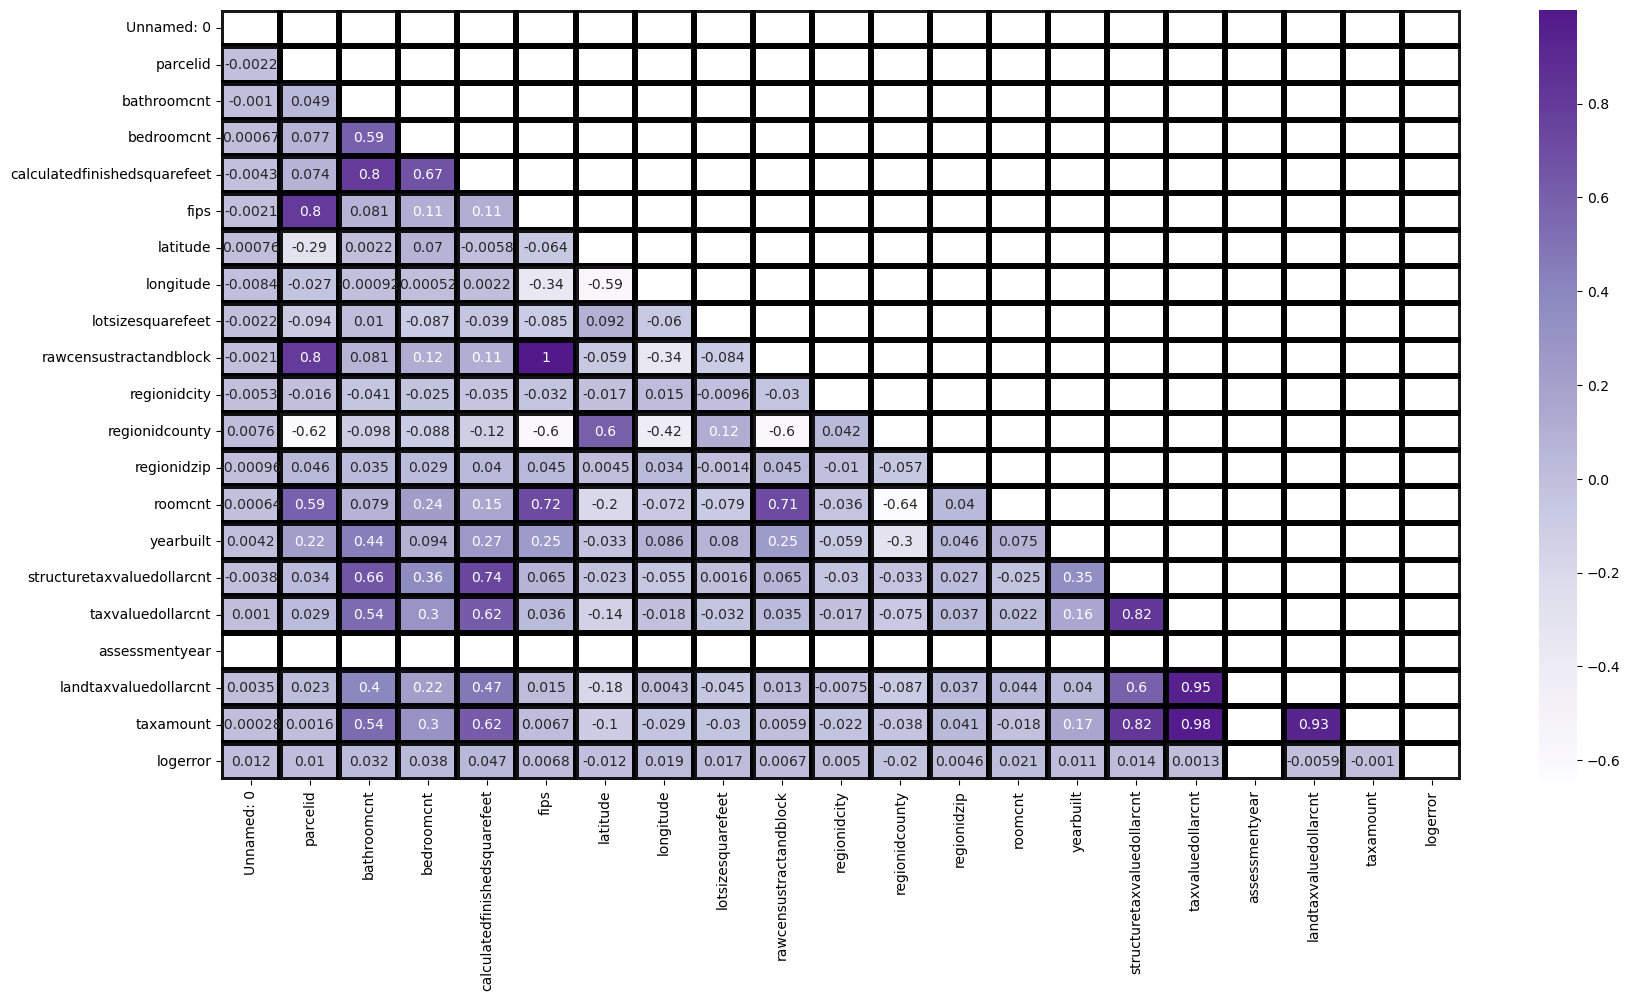

In [11]:
# Pass my correlation matrix to Seaborn's heatmap.
kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}
plt.figure(figsize=(20,10))
sns.heatmap(train_corr, cmap='Purples', annot=True, mask= np.triu(train_corr), **kwargs)
#plt.ylim(10, 10)

plt.show()

> Looking at the heat map for correlation:
    - 'assessmentyear' doesn't factor
    
    ** Biggest Correlation
        - parcelid
        - bathroomcnt
        - bedroomcnt
        - calculatedfinishedsquarefeet
        - longitude
        - lotsizesquarefeet
        - roomcnt
        - yearbuilt
        - structuretaxvaluedollarcnt
        
    ** Mid Correlation
        - fips
        - rawcensustractandblock
        - regionidcity
        - regionidzip
        - taxvaluedollarcnt
    
    ** Lowest Correlation
        - taxamount
        - landtaxvaluedollarcnt
        - regionidcounty
        - latitude

In [12]:
#Grouping my 'Biggest Correlation Features together for further exploration'
train_bigC = train[['logerror','parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'longitude', 'lotsizesquarefeet',  'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt']]

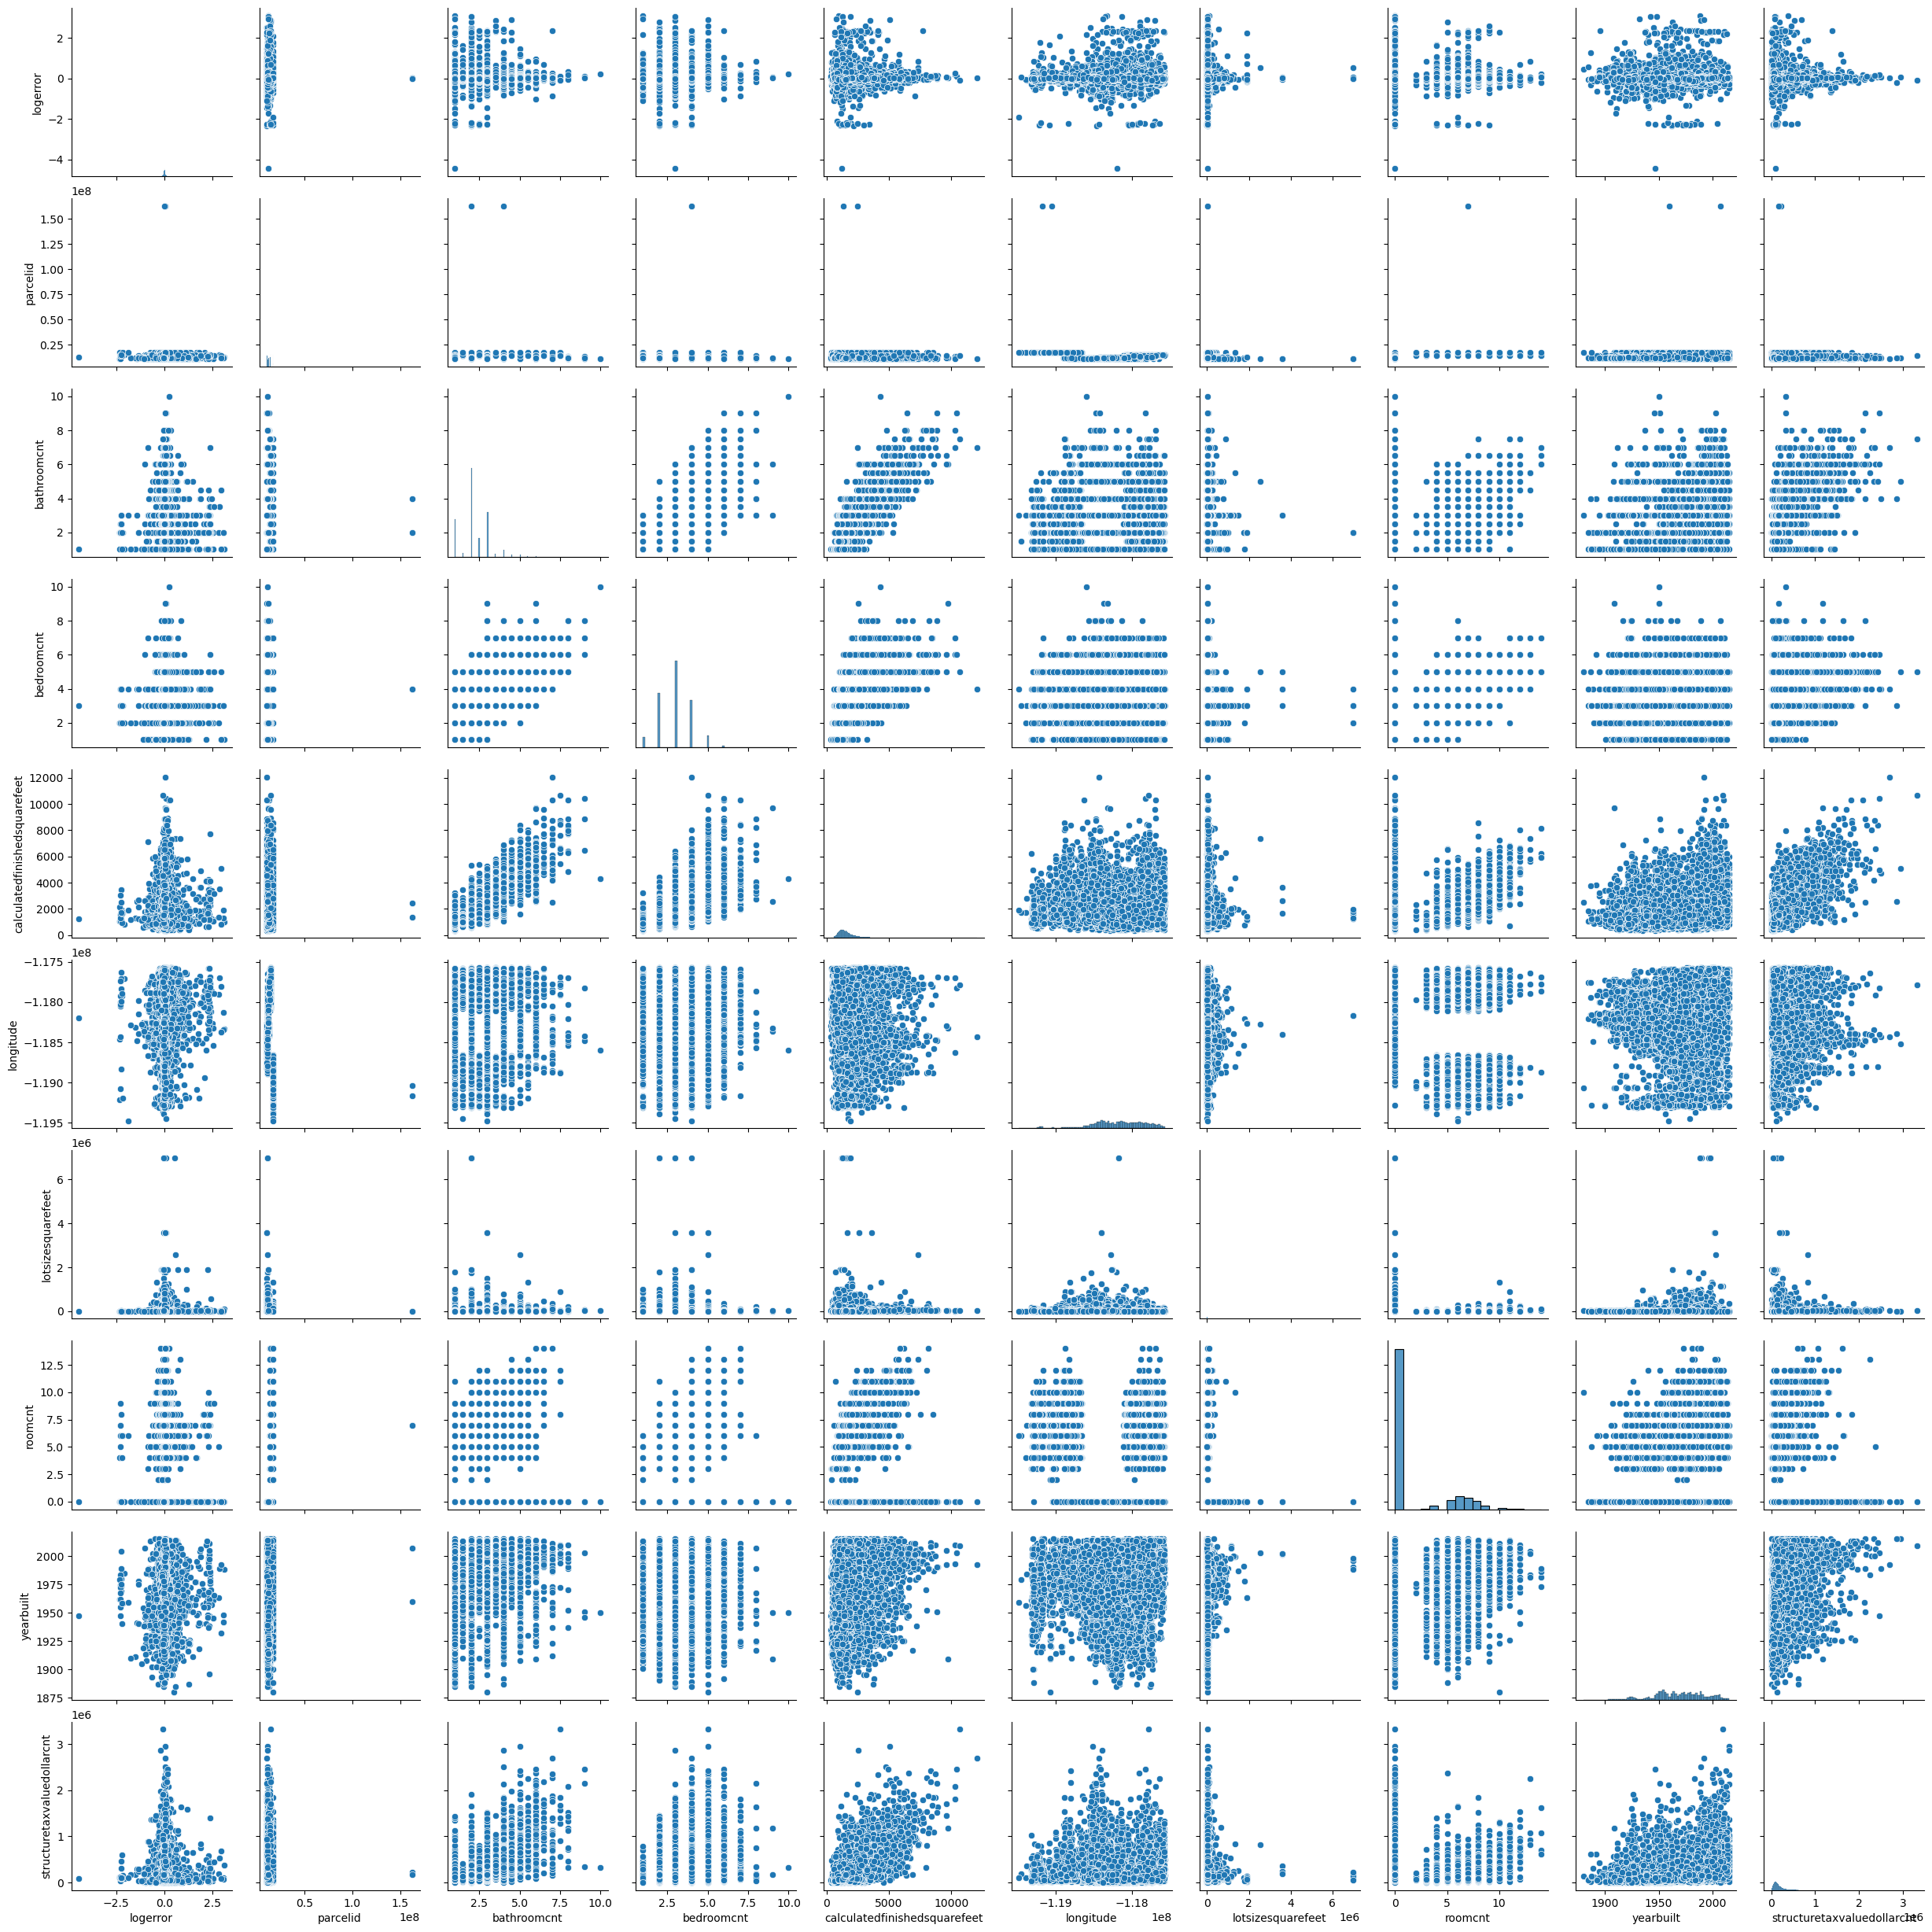

In [13]:
sns.pairplot(train_bigC)

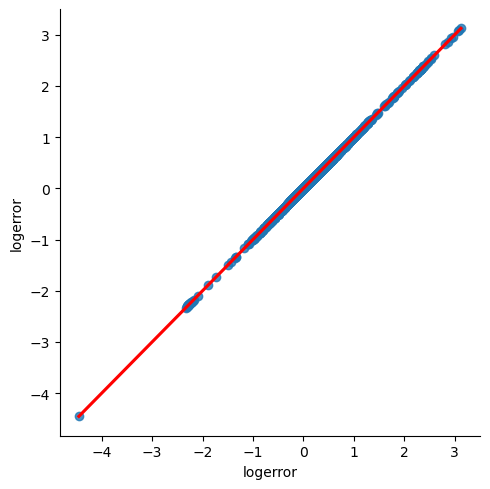

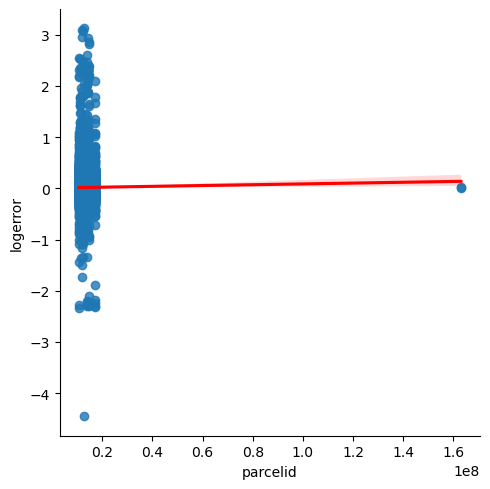

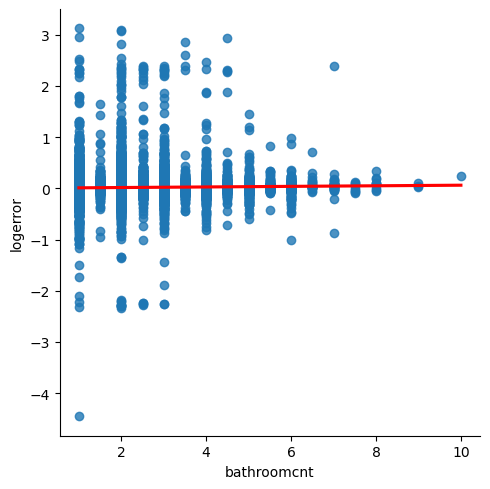

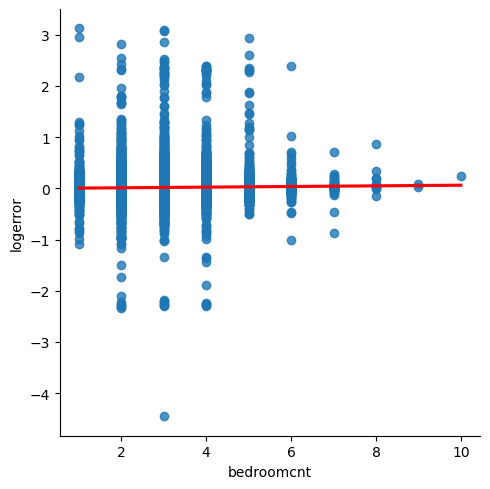

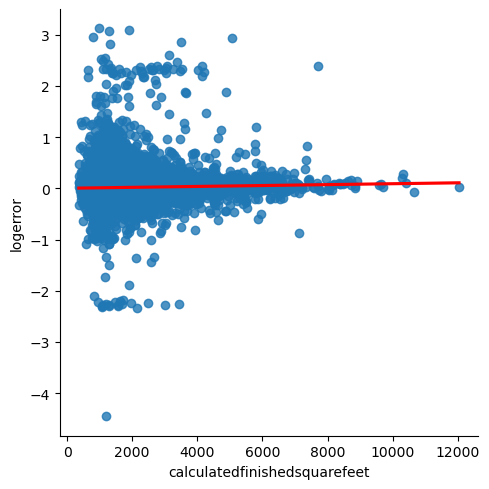

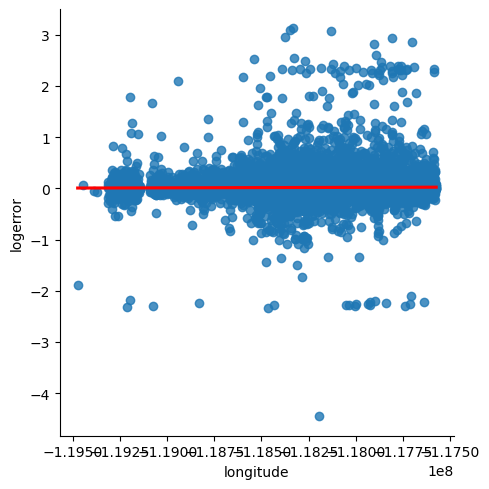

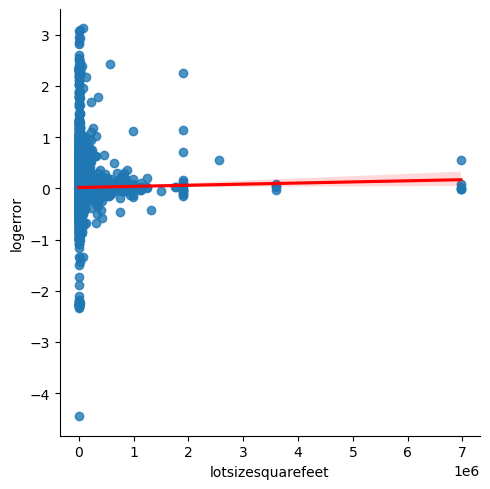

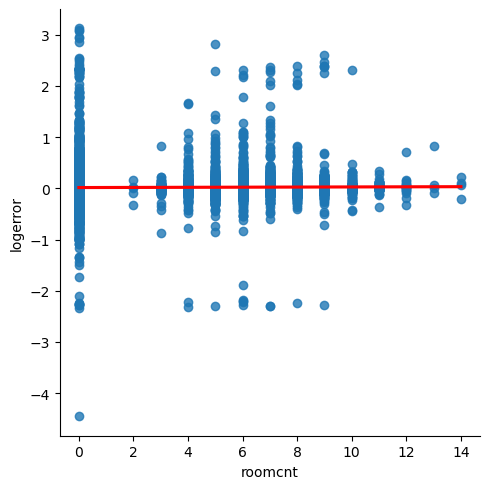

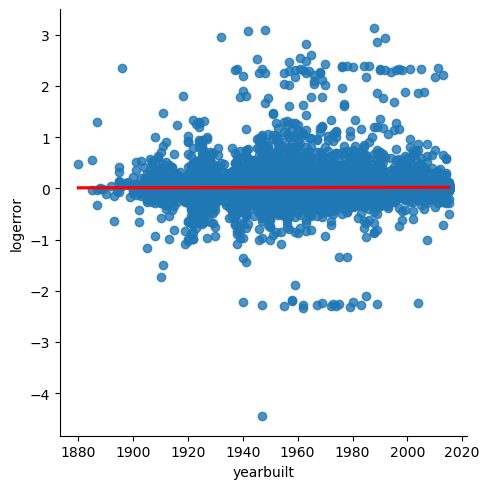

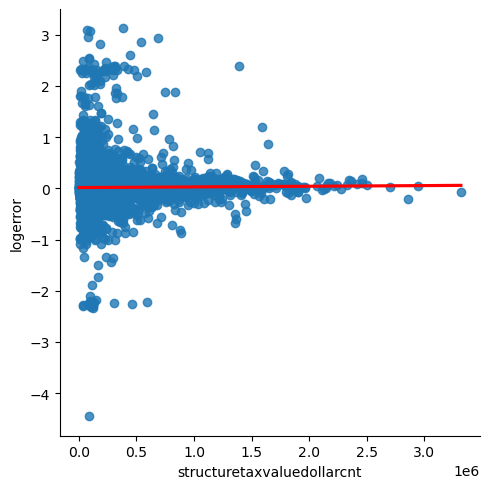

In [14]:
# Scatterplot with a regression line
for col in train_bigC:
    sns.lmplot(x=col, y="logerror", data=train_bigC, line_kws={'color': 'red'})
    plt.show()


LOGERROR
count of unique: 38890


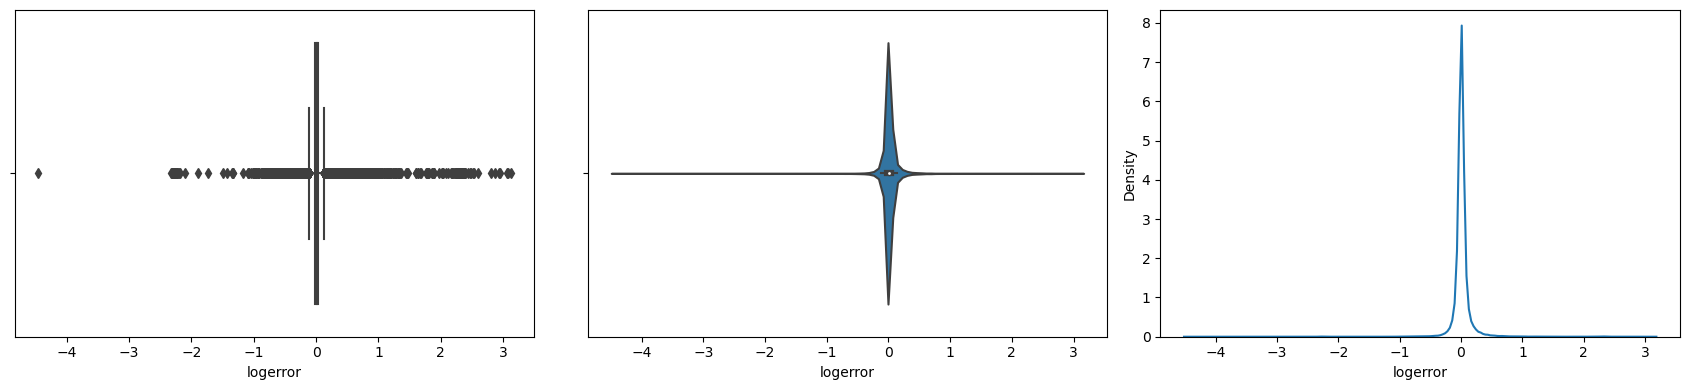

PARCELID
count of unique: 39000


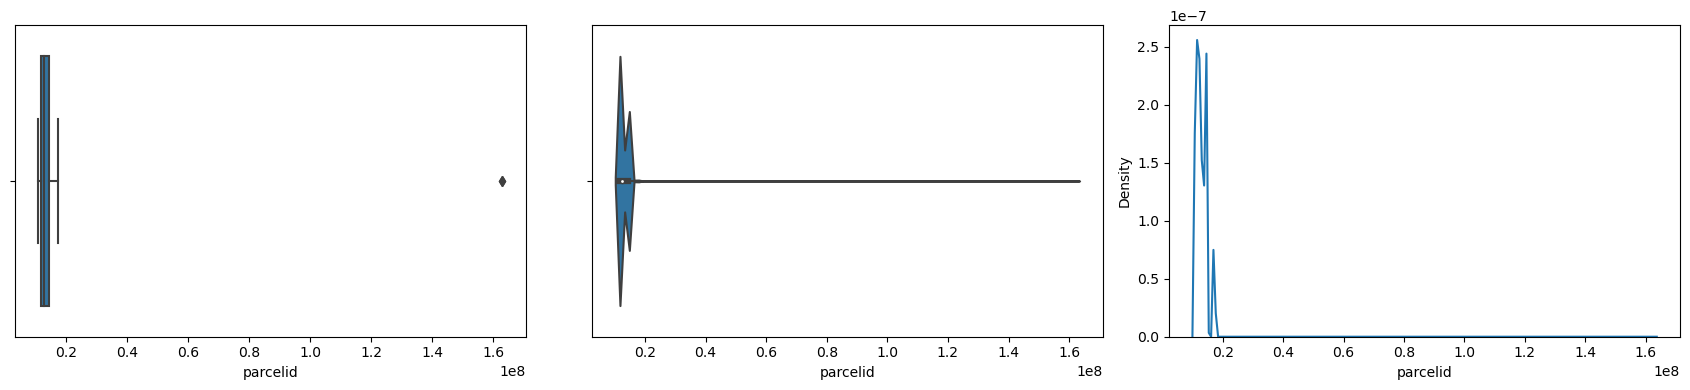

BATHROOMCNT
count of unique: 17


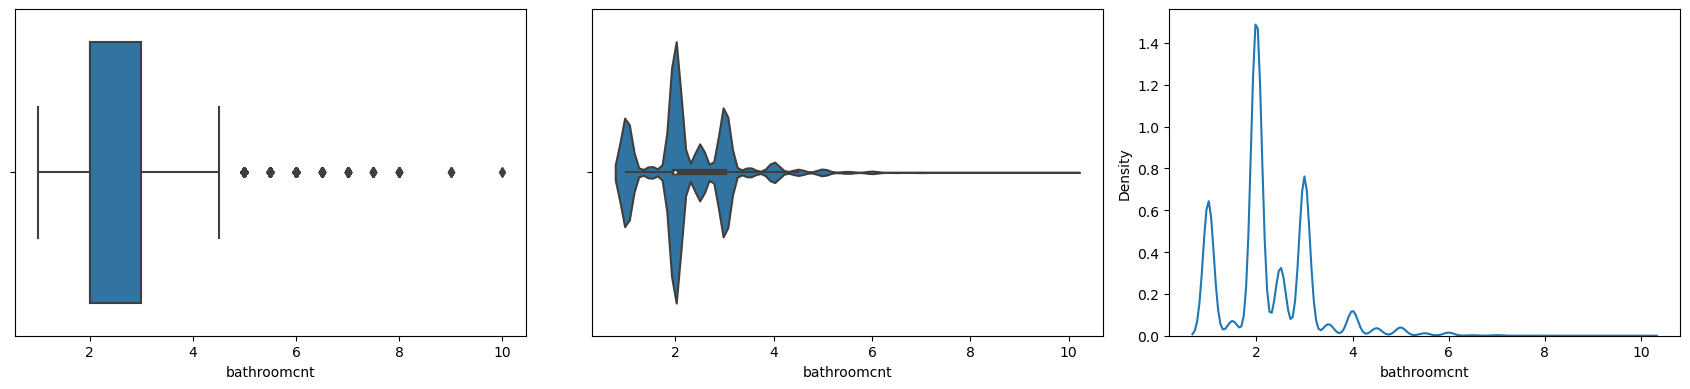

BEDROOMCNT
count of unique: 10


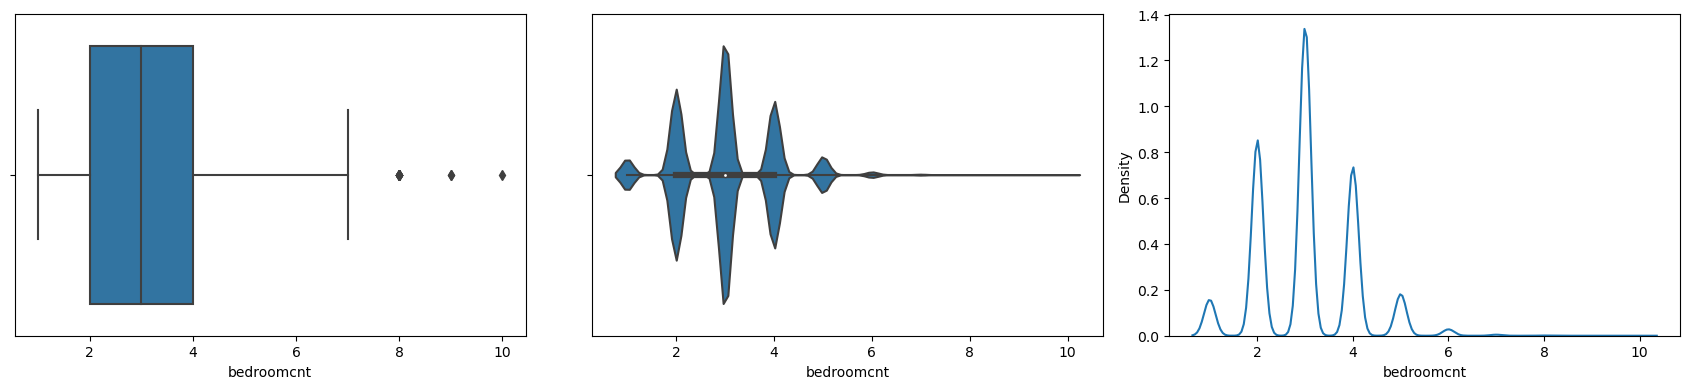

CALCULATEDFINISHEDSQUAREFEET
count of unique: 4097


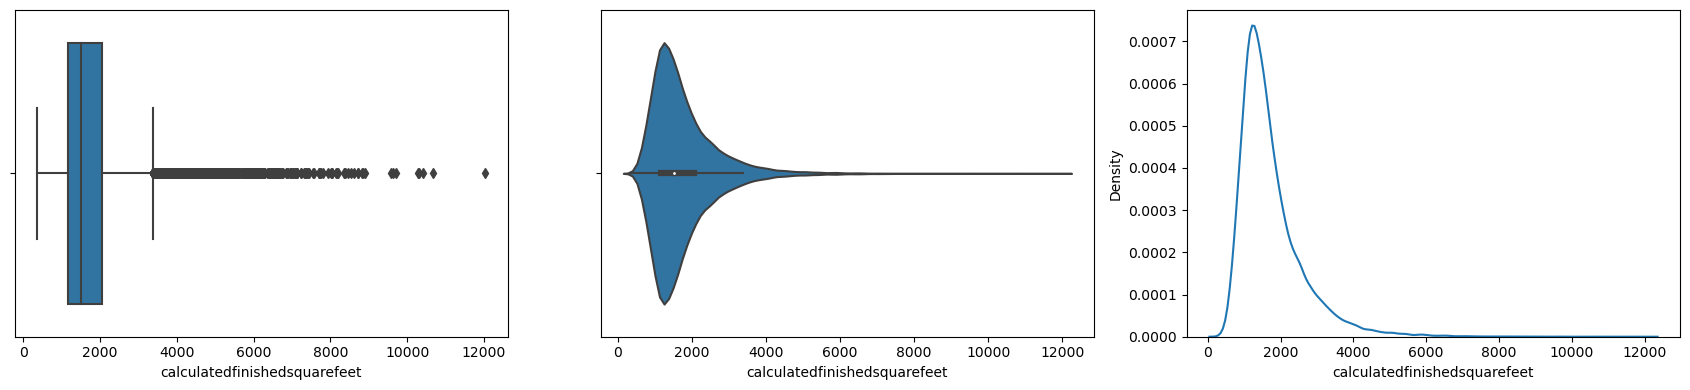

LONGITUDE
count of unique: 32371


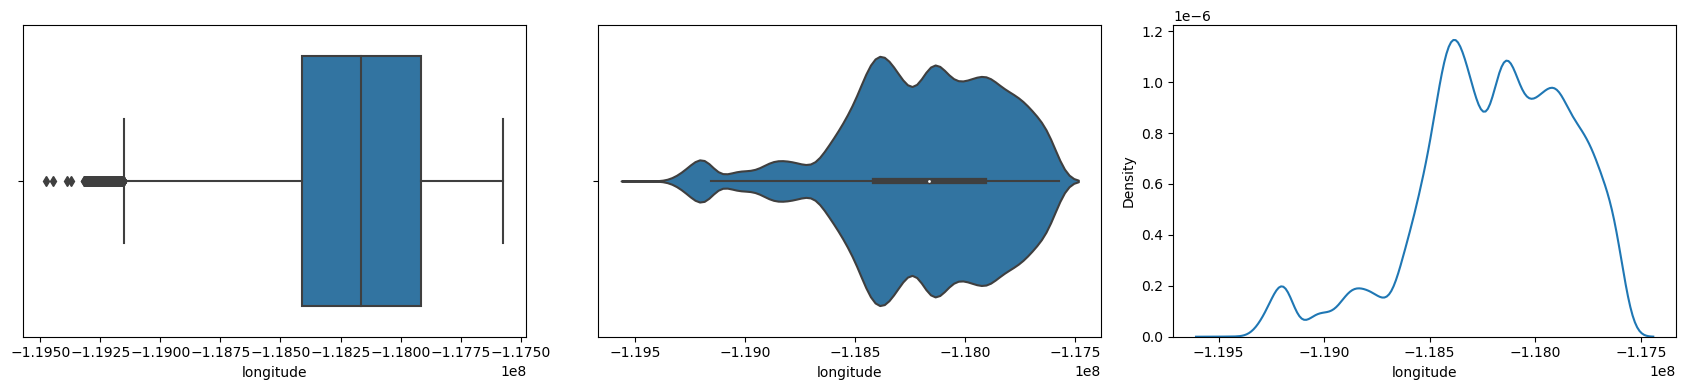

LOTSIZESQUAREFEET
count of unique: 13292


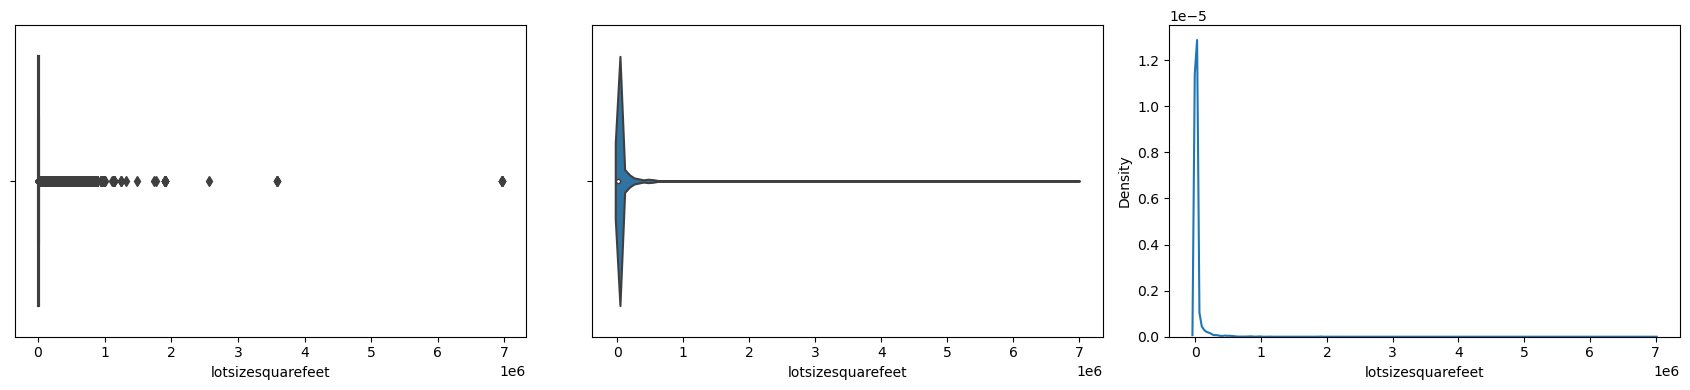

ROOMCNT
count of unique: 14


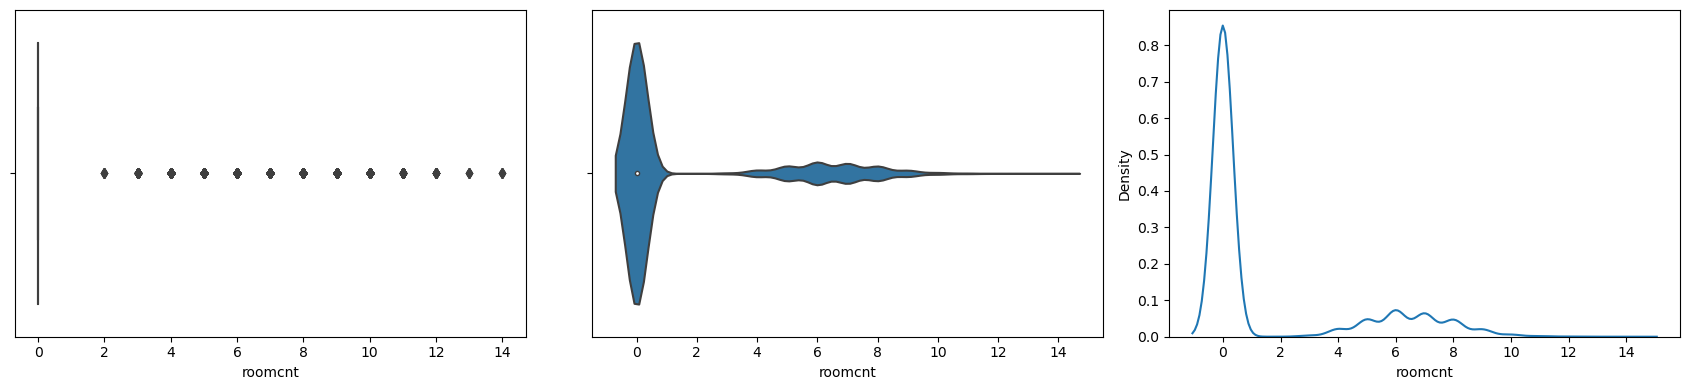

YEARBUILT
count of unique: 130


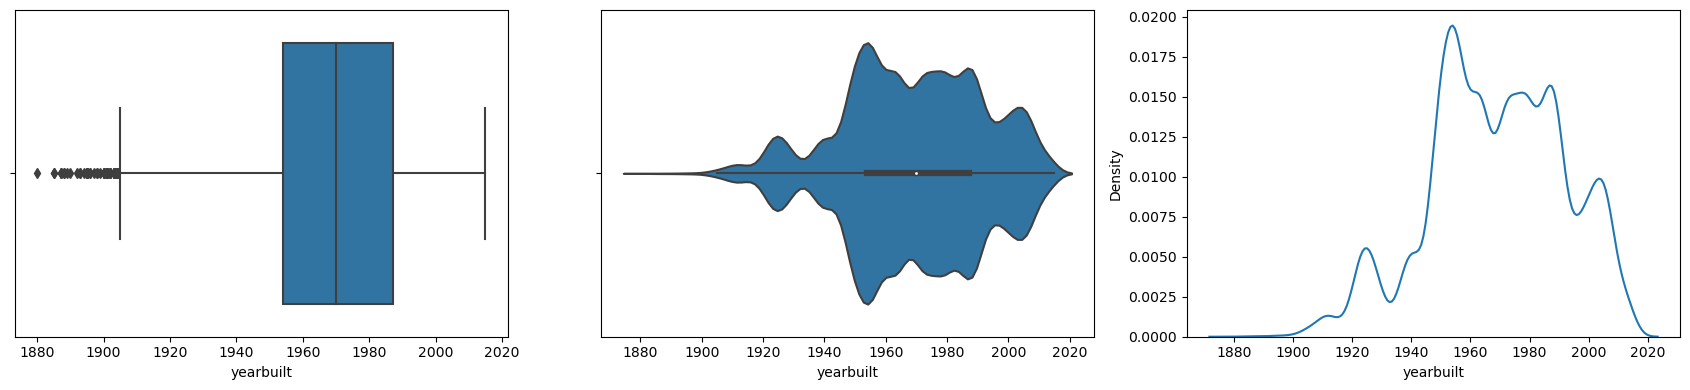

STRUCTURETAXVALUEDOLLARCNT
count of unique: 29079


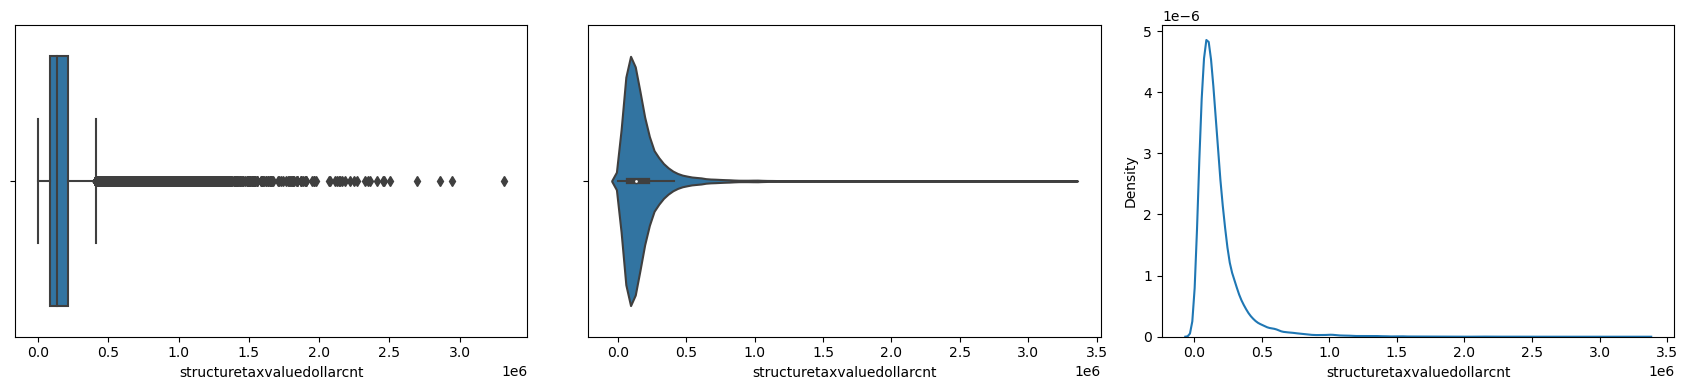

In [15]:
for col in train_bigC:
    print(col.upper())
    print("count of unique:",train_bigC[col].nunique())
    # plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
    sns.boxplot(data= train_bigC, x=col, ax=ax[0])
    sns.violinplot(data= train_bigC, x=col, ax=ax[1])
    sns.kdeplot(train_bigC, x=col, ax=ax[2])
    plt.tight_layout()
    plt.show()

In [16]:
#make new age_bin column
#adding a label is helpful for calling that column!
train['logerror_bins'] = pd.cut(train.logerror,[-5,0,5], labels=['below_0', 'over_0'])
train['logerror_bins']

62073     over_0
33306    below_0
13036     over_0
51272    below_0
41963    below_0
          ...   
26358    below_0
64806     over_0
58155     over_0
51100    below_0
62305    below_0
Name: logerror_bins, Length: 39048, dtype: category
Categories (2, object): ['below_0' < 'over_0']

<h3><b>My 5 Questions

> <b>Question 1:  Why does the logerror have a wide dispersement when Structuretaxvaluedollarcnt is in the range of 0 to 1.00okm(IJN8uhb&YGV

> <b>Question 2: Why does the logerror vary when bathroomcnt is lower?

> <b>Question 3: What feature, coupled with Calculatedfinishedsquarefeet, factors into a negative or positive logerror?

> <b>Question 4: Why is the 'bedroom count' skewed toward positive logerror?

> <b>Question 5: Is there a relationship between yearbuilt and logerror?

<h2><b>Answer those questions through a mix of statistical tests and visualizations.

<h3><b>Question 1:  Is there a relationship between logerror and Structuretaxvaluedollarcnt?

> > <b>Visual:

<Axes: xlabel='logerror_bins', ylabel='structuretaxvaluedollarcnt'>

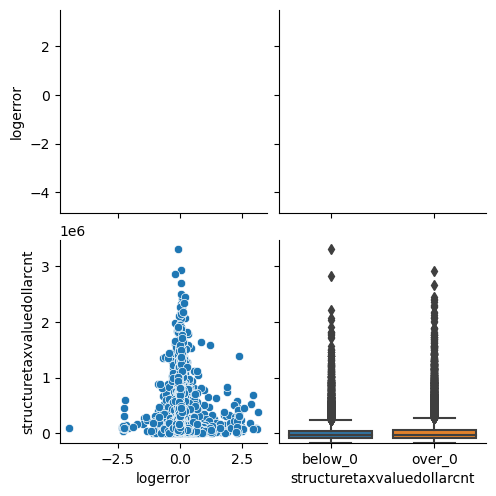

In [17]:
just_two = train_bigC[['logerror', 'structuretaxvaluedollarcnt']]
sns.pairplot(data=just_two)

sns.boxplot(data=train, x='logerror_bins', y='structuretaxvaluedollarcnt')

> > <b>Statistical Test: 2-sample, 2-tail, t-test

variance null hypothesis: The two variances are equal.

In [48]:
relationship_null = 'There is no relationship between "logerror" and "structuretaxvaluedollarcnt"'
relationship_alternative = 'There IS a relationship between "logerror" and "structuretaxvaluedollarcnt"'

alpha = 0.05

In [39]:
#stats.levene
stats.levene(train['logerror'], train['structuretaxvaluedollarcnt'])

LeveneResult(statistic=15729.504449965563, pvalue=0.0)

The pvalue is less than the alpha, so I reject the null hypothesis. My variances are NOT equal.

In [40]:
t, p = stats.ttest_ind(train['logerror'], train['structuretaxvaluedollarcnt'], equal_var=False)
t, p

(-198.4344421447439, 0.0)

In [64]:
if p < alpha:
    print("Reject null hypothesis? ", p < alpha)
    print(f'{relationship_alternative}')

else:
    print("Fail to Reject null hypothesis? ", p > alpha)
    print(f'{relationship_null}')

Reject null hypothesis?  True
There IS a relationship between "logerror" and "calculatedfinishedsquarefeet"


<h3><b>Question 2: Is there a relationship between 'logerror' and 'bathroomcnt'?

> > <b>Visual:

<Axes: xlabel='logerror_bins', ylabel='bathroomcnt'>

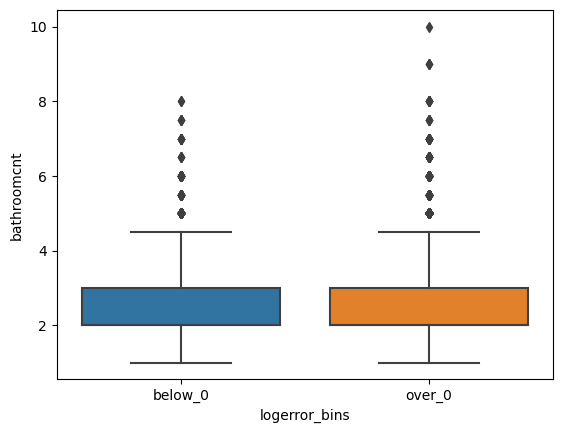

In [23]:
sns.boxplot(data=train, x='logerror_bins', y='bathroomcnt')

> > <b>Statistical Test: 2-sample, 2-tail, t-test

variance null hypothesis: The two variances are equal.

In [51]:
relationship_null = 'There is no relationship between "logerror" and "bathroomcnt"'
relationship_alternative = 'There IS a relationship between "logerror" and "bathroomcnt"'

alpha = 0.05

In [52]:
#stats.levene
stats.levene(train['logerror'], train['bathroomcnt'])

LeveneResult(statistic=23387.871704827587, pvalue=0.0)

The pvalue is less than the alpha, so I reject the null hypothesis. My variances are NOT equal.

In [60]:
t, p = stats.ttest_ind(train.logerror, train.bathroomcnt, equal_var=False)
t, p

(-473.90230643912315, 0.0)

In [63]:
if p < alpha:
    print("Reject null hypothesis? ", p < alpha)
    print(f'{relationship_alternative}')

else:
    print("Fail to Reject null hypothesis? ", p > alpha)
    print(f'{relationship_null}')

Reject null hypothesis?  True
There IS a relationship between "logerror" and "calculatedfinishedsquarefeet"


<h3><b>Question 3: Is there a relationship between Calculatedfinishedsquarefeet and logerror?

> > <b>Visual:

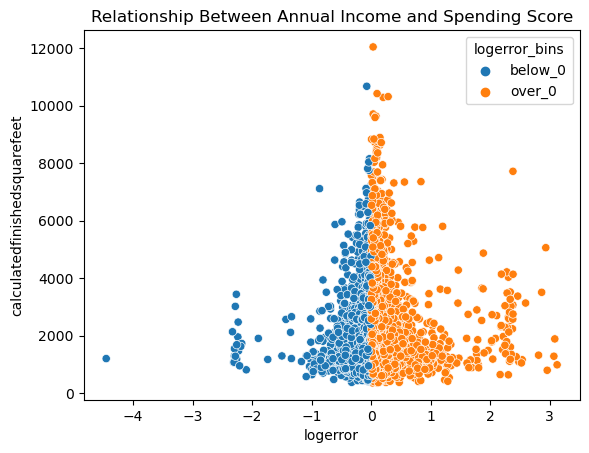

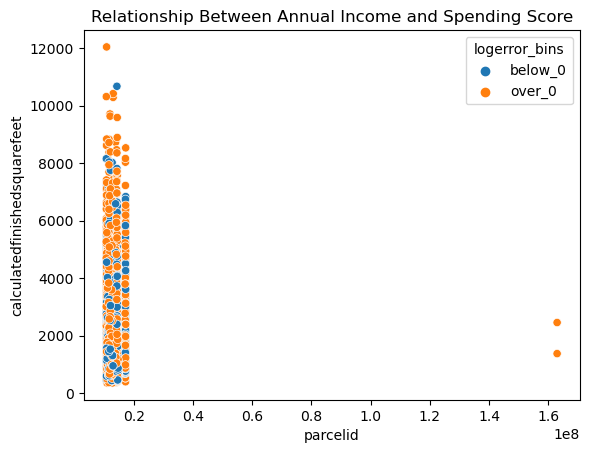

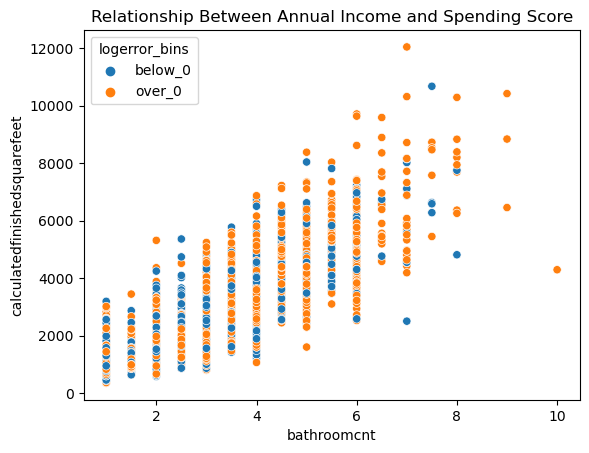

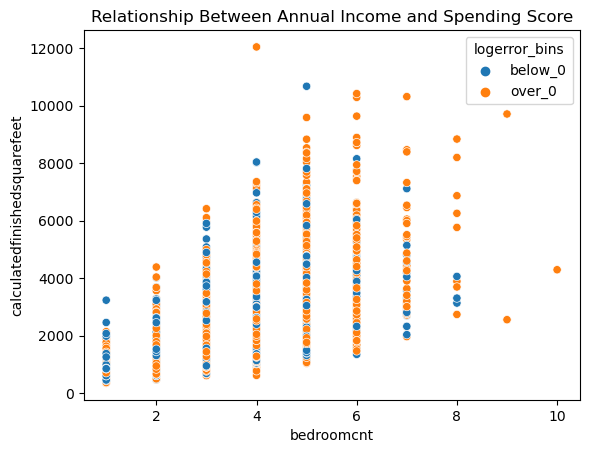

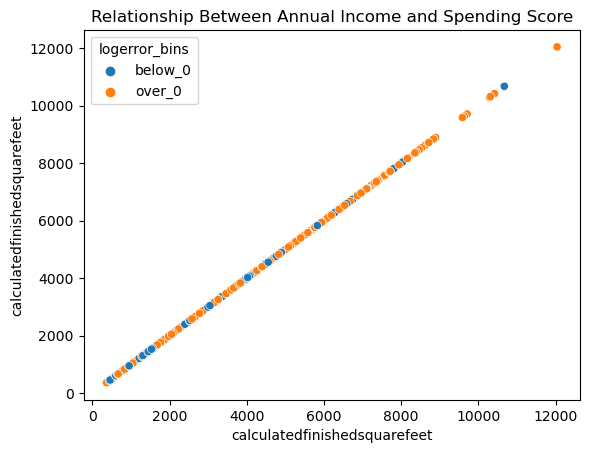

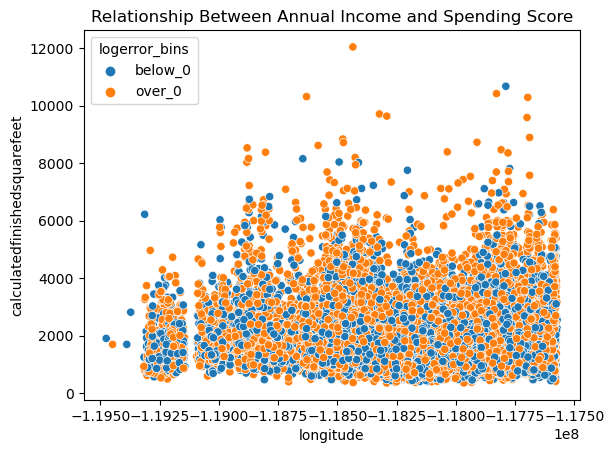

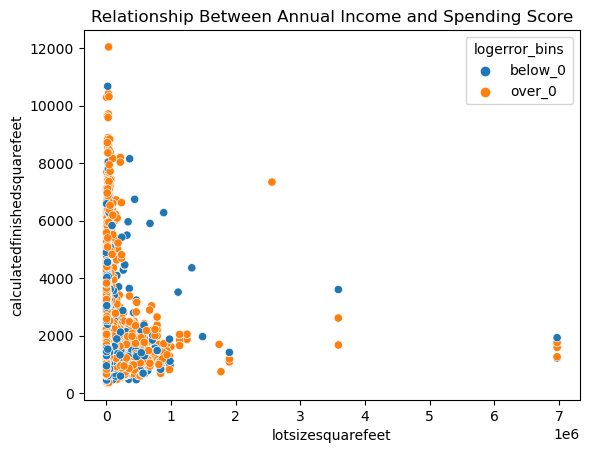

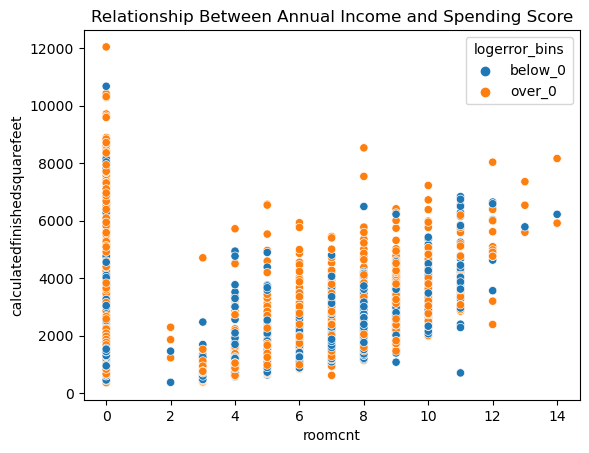

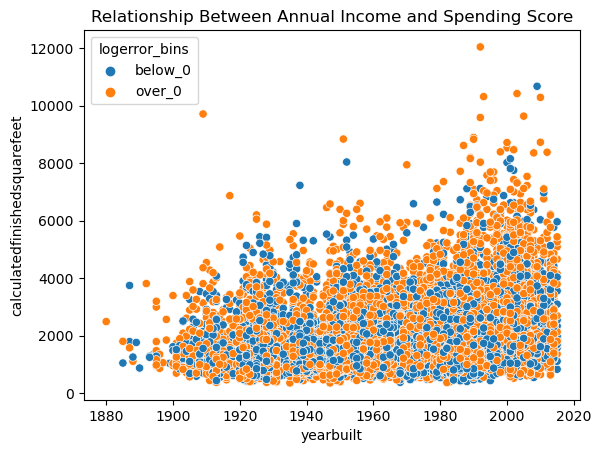

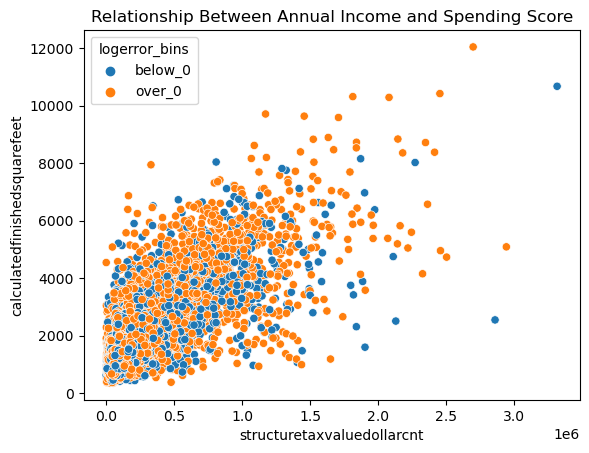

In [29]:
for col in train_bigC:
    sns.scatterplot(data=train_bigC, x=col, y='calculatedfinishedsquarefeet', hue=train.logerror_bins)
    plt.show()

<b> I don't see anything from this visual tells me anything, so let me see if there is any relationship.

> > <b>Statistical Test:

variance null hypothesis: The two variances are equal.

In [55]:
relationship_null = 'There is no relationship between "logerror" and "calculatedfinishedsquarefeet"'
relationship_alternative = 'There IS a relationship between "logerror" and "calculatedfinishedsquarefeet"'

alpha = 0.05

In [56]:
#stats.levene
stats.levene(train['logerror'], train['calculatedfinishedsquarefeet'])

LeveneResult(statistic=29896.54161205432, pvalue=0.0)

The pvalue is less than the alpha, so I reject the null hypothesis. My variances are NOT equal.

In [57]:
t, p = stats.ttest_ind(train['logerror'], train['calculatedfinishedsquarefeet'], equal_var=False)
t, p

(-391.0838766545318, 0.0)

In [65]:
if p < alpha:
    print("Reject null hypothesis? ", p < alpha)
    print(f'{relationship_alternative}')

else:
    print("Fail to Reject null hypothesis? ", p > alpha)
    print(f'{relationship_null}')

Reject null hypothesis?  True
There IS a relationship between "logerror" and "calculatedfinishedsquarefeet"


<h3><b>Question 4: Is there a relationship between 'bedroom count' and 'logerror'?

> > <b>Visual:

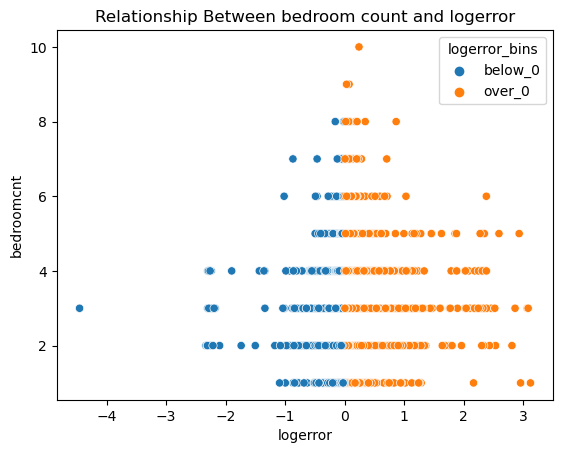

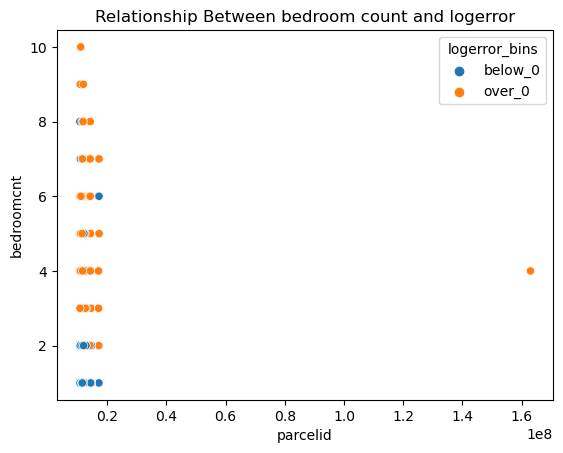

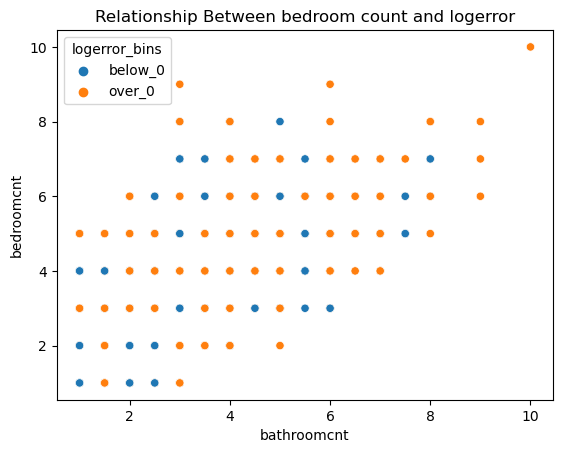

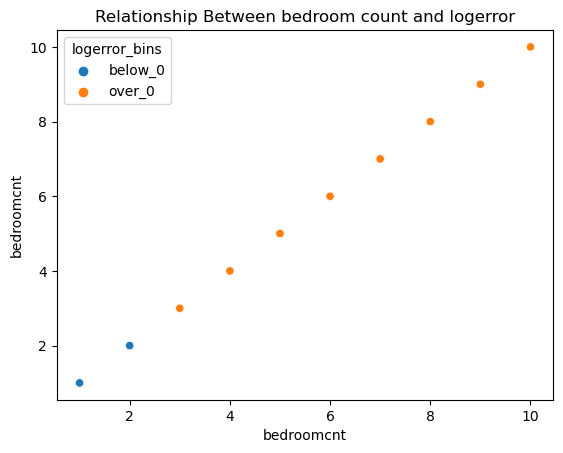

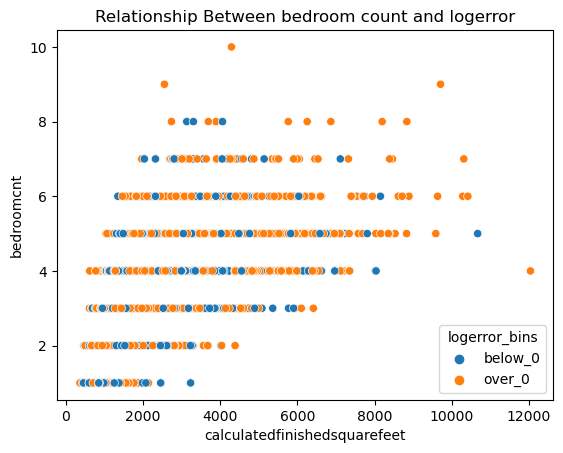

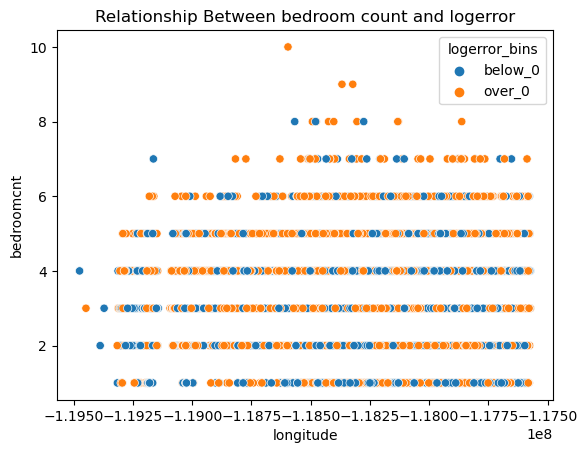

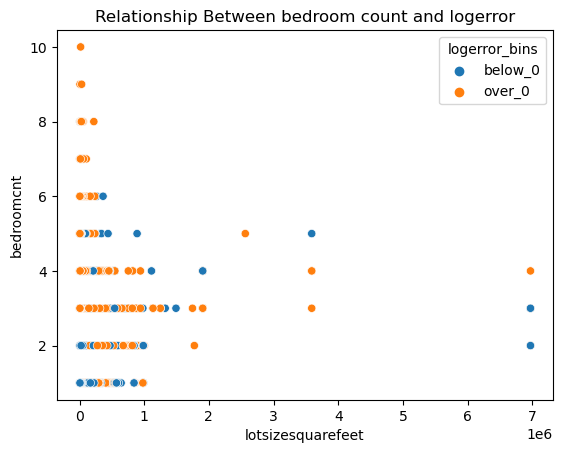

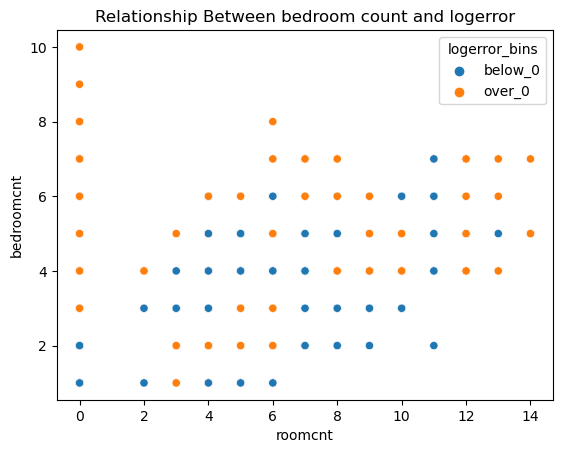

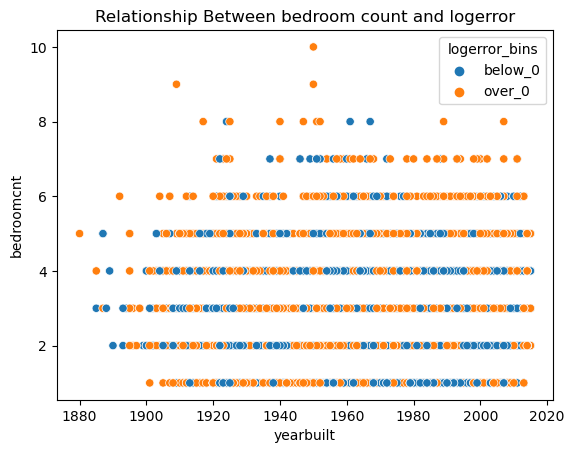

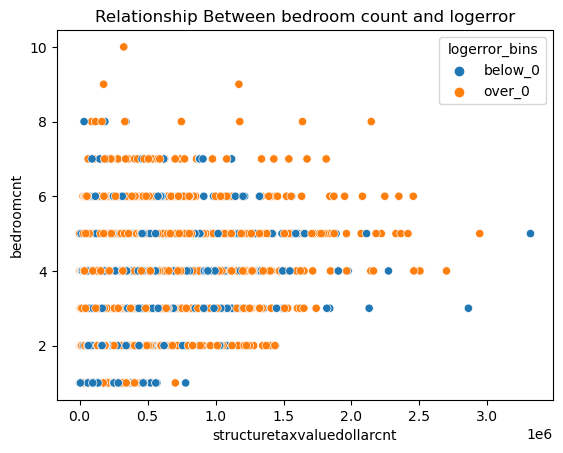

In [33]:
for col in train_bigC:
    sns.scatterplot(data=train_bigC, x=col, y='bedroomcnt', hue=train.logerror_bins)
    plt.title('Relationship Between bedroom count and logerror')
    plt.show()

 <b>- Once a home hits 3 bedrooms, the logerror is positive

> > <b>Statistical Test:

variance null hypothesis: The two variances are equal.

In [48]:
relationship_null = 'There is no relationship between "logerror" and "bedroomcnt"'
relationship_alternative = 'There IS a relationship between "logerror" and "bedroomcnt"'

alpha = 0.05

In [39]:
#stats.levene
stats.levene(train['logerror'], train['bedroomcnt'])

LeveneResult(statistic=15729.504449965563, pvalue=0.0)

The pvalue is less than the alpha, so I reject the null hypothesis. My variances are NOT equal.

In [40]:
t, p = stats.ttest_ind(train['logerror'], train['bedroomcnt'], equal_var=False)
t, p

(-198.4344421447439, 0.0)

In [70]:
if p < alpha:
    print("Reject null hypothesis? ", p < alpha)
    print(f'{relationship_alternative}')

else:
    print("Fail to Reject null hypothesis? ", p > alpha)
    print(f'{relationship_null}')

Reject null hypothesis?  True
There IS a relationship between "logerror" and "yearbuilt"


<h3><b>Question 5: Is there a relationship between yearbuilt and logerror?

> > <b>Visual:

<Axes: xlabel='logerror_bins', ylabel='yearbuilt'>

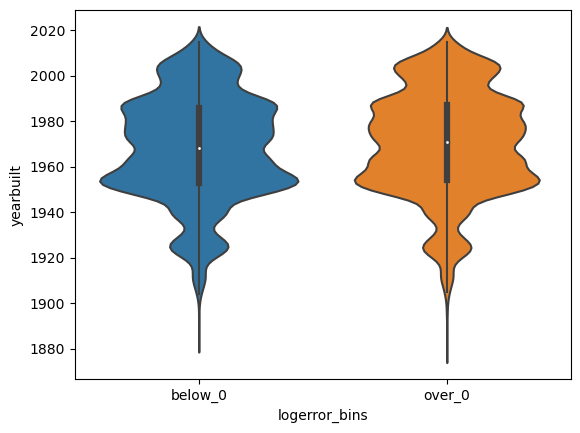

In [37]:
sns.violinplot(data=train, x=train.logerror_bins, y='yearbuilt')

<Axes: xlabel='logerror_bins', ylabel='yearbuilt'>

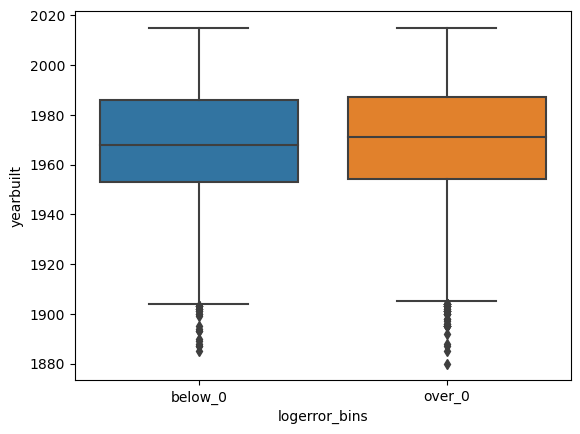

In [38]:
sns.boxplot(data=train, x=train.logerror_bins, y='yearbuilt')

> <b> There seems to be no difference between the two bins of logerror, but logerror is mostly grouped between a specific set of years.

> > <b>Statistical Test:

variance null hypothesis: The two variances are equal.

In [66]:
relationship_null = 'There is no relationship between "logerror" and "yearbuilt"'
relationship_alternative = 'There IS a relationship between "logerror" and "yearbuilt"'

alpha = 0.05

In [67]:
#stats.levene
stats.levene(train['logerror'], train['yearbuilt'])

LeveneResult(statistic=79053.57839650211, pvalue=0.0)

The pvalue is less than the alpha, so I reject the null hypothesis. My variances are NOT equal.

In [68]:
t, p = stats.ttest_ind(train['logerror'], train['yearbuilt'], equal_var=False)
t, p

(-16891.75576987791, 0.0)

In [71]:
if p < alpha:
    print("Reject null hypothesis? ", p < alpha)
    print(f'{relationship_alternative}')

else:
    print("Fail to Reject null hypothesis? ", p > alpha)
    print(f'{relationship_null}')

Reject null hypothesis?  True
There IS a relationship between "logerror" and "yearbuilt"
